In [ ]:
# !pip install transformers
!pip install datasets
# !pip install pandas
# !pip install torch
# !pip install sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import transformers
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [ ]:
# Load model
from transformers import BertTokenizer, BertForSequenceClassification
model_path = '/content/drive/MyDrive/yelp_model-128-16'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
print(model)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Load yelp dataseet
dataset = load_dataset("yelp_review_full")
df_test = pd.DataFrame(dataset['test'])

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
class YelpDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
df = df_test[:1600]

In [ ]:
# Create instances of the custom dataset
test_dataset = YelpDataset(texts=df['text'].values, labels=df['label'].values, tokenizer=tokenizer)

# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
model.eval()
with torch.no_grad():
    predictions = []
    originals = []
    total_samples = 0

    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        preds = torch.argmax(outputs.logits, dim=1)
        originals += labels.tolist()
        predictions += preds.tolist()

        progress = len(batch) / len(test_loader)
        progress_bar = "=" * int(20 * progress) + " " * (20 - int(20 * progress))
        print(f"\rBatch [{len(batch)}/{len(test_loader)}] | Progress: [{progress_bar}]", end="\r")

In [ ]:
def five_to_binary(array):
  result = []
  for a in array:
    if a < 2:
      result.append(0) # negtive
    else:
      result.append(1) # positive
  return result

In [ ]:
ori = five_to_binary(originals)
pre = five_to_binary(predictions)

In [ ]:
acc = 0
for o, p in zip(ori, pre):
  if o == p: acc+=1

In [ ]:
acc/len(originals)

0.82375

In [ ]:
import time
input_text = df_test.loc[0]['text']
input_ids = tokenizer.encode(input_text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
input_ids = input_ids.to(device)
attention_mask = torch.ones(input_ids.shape, dtype=torch.long).to(device)
start = time.time()
outputs = model(input_ids, attention_mask=attention_mask)
end = time.time()
print('time:', end-start)
print(outputs.logits)
pos_score = outputs.logits.tolist()[0][:2]
neg_score = outputs.logits.tolist()[0][2:5]
print(sum(pos_score), sum(neg_score))
preds = torch.argmax(outputs.logits, dim=1)
print('prediction:', preds.item())
print('label:', df_test.loc[0]['label'])

time: 0.021132707595825195
tensor([[-0.1584, -0.0948, -0.2343, -0.5616,  0.2884]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
-0.25323960930109024 -0.5074715465307236
prediction: 4
label: 0


In [ ]:
# Count the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters())

# Display the number of parameters
print(f"Number of parameters in {model}: {num_params}")

Number of parameters in BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

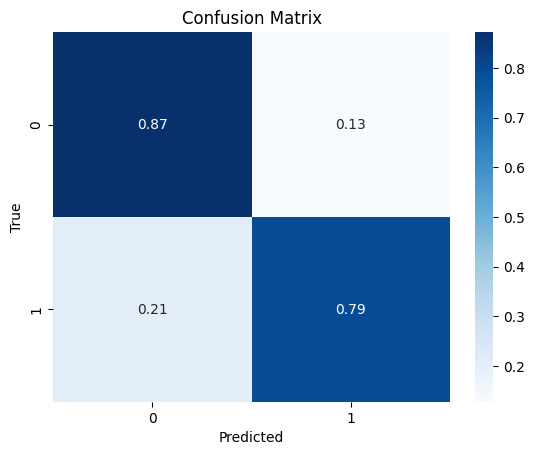

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ori, pre)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()